# Developing Functions for sedproxy in Python (Dolman & Laepple 2018)

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns


## Calib.Functions.R
Function proxy_conversion

In [26]:
def proxy_conversion(temp=None, proxy_val=None, calib_type=None,
                     slp_int_mean=None, slp_int_vcov=None,
                     calib=None,point_or_sample="point", n=1,
                     calib_parameters=None):
    """
    Convert temperature to proxy value (or back) using sedproxy calibrations.

    Parameters:
    ----------
    temp : array-like or None
        Input temperature values.
    proxy_val : array-like or None
        Input proxy values (inverse conversion).
    calib_type : str
        One of 'identity', 'MgCa', 'Uk37'.
    slp_int_means : array-like or None
        User-supplied [slope, intercept] means.
    slp_int_vcov : array-like or None
        User-supplied 2x2 variance-covariance matrix.
    calib : str or None
        Calibration dataset name (defaults handled in R code).
    point_or_sample : str
        'point' for deterministic, 'sample' for sampling calibration parameters.
    n : int
        Number of replicates if sampling.
    calib_parameters : DataFrame or dict
        Calibration parameters table with slope, intercept, vcov, etc.
    """
     
    # checks for correct input type
    if (temp is None and proxy_val is None) or (temp is not None and proxy_val is not None):
     raise ValueError("One and only one of temp or proxy_val should be supplied")

    if point_or_sample not in ["point", "sample"]:
        raise ValueError("point_or_sample must be 'point' or 'sample'")

    # checks for correct array size
    if isinstance(temp, np.ndarray) and temp.ndim == 2:
        if point_or_sample == "sample" and temp.shape[1] != n:
            raise ValueError("For matrix input and 'sample' mode, n must equal number of columns in input")

    if point_or_sample == "point" and n > 1:
        raise ValueError("Multiple replicates only allowed if point_or_sample == 'sample'")

    # Get calibration parameters
    if calib_type != "identity":
        if calib_parameters is None:
            raise ValueError("Calibration parameters must be provided")

        # Extract relevant parameters (simulate dataframe filtering)
        cfs_vcov = calib_parameters[
            (calib_parameters['calibration_type'] == calib_type) &
            (calib_parameters['calibration'] == calib)
        ].iloc[0]

        if slp_int_mean is None:
            cfs = np.array([[cfs_vcov['slope'], cfs_vcov['intercept']]])
        else:
            cfs = np.array([slp_int_mean])

        if slp_int_vcov is None:
            vcov = cfs_vcov['vcov']
        else:
            vcov = slp_int_vcov

        # Sample calibration parameters if requested
        if point_or_sample == "sample":
            if slp_int_mean is not None and slp_int_vcov is None:
                print("Warning: Sampling calibration parameters with user-supplied means but default VCOV.")
            cfs = multivariate_normal.rvs(mean=cfs.flatten(), cov=vcov, size=n)
            cfs = cfs.reshape((n, 2))

    # Prepare input arrays
    if isinstance(temp, (list, np.ndarray)):
        temp = np.atleast_2d(temp)
    if isinstance(proxy_val, (list, np.ndarray)):
        proxy_val = np.atleast_2d(proxy_val)

    # Ensure temp and proxy_val are 2D column vectors
    if temp is not None:
        temp = np.atleast_2d(temp).reshape(-1, 1)
    if proxy_val is not None:
        proxy_val = np.atleast_2d(proxy_val).reshape(-1, 1)


    # Conversion logic
    if calib_type == "identity":
        out = proxy_val if temp is None else temp


    elif calib_type == "MgCa":
        cfs[:, 1] = np.exp(cfs[:, 1])  # exponentiate intercept

        if temp is not None:
            temp = temp.reshape(-1, 1)  # shape (3, 1)

        if proxy_val is None:
            slope = cfs[:, 0].reshape(1, -1)      # shape (1, n)
            intercept = cfs[:, 1].reshape(1, -1)   # shape (1, n)
            out = intercept * np.exp(slope * temp)  # shape (3, n)
        else:
            proxy_val = proxy_val.reshape(-1, 1)
            slope = cfs[:, 0].reshape(1, -1)
            intercept = cfs[:, 1].reshape(1, -1)
            out = np.log(proxy_val / intercept) / slope

            
    elif calib_type == "Uk37":
        if proxy_val is None:
            out = (cfs[:, 1] + temp.T * cfs[:, 0]).T
        else:
            out = ((proxy_val.T - cfs[:, 1]) / cfs[:, 0]).T

    else:
        raise ValueError(f"Unknown calibration_type: {calib_type}")

    # Simplify output if it was vector input and n == 1
    if out.shape[1] == 1:
        out = out.flatten()

    return out


In [27]:

# Dummy calibration_parameters table
calibration_parameters = pd.DataFrame({
    'calibration_type': ['MgCa', 'Uk37'],
    'calibration': ['Ten planktonic species_350-500', 'Mueller global'],
    'slope': [0.09, 0.033],
    'intercept': [np.log(0.38), 0.1],
    'vcov': [np.array([[0.0001, 0], [0, 0.01]]), np.array([[0.00005, 0], [0, 0.005]])]
})


In [ ]:
from scipy.stats import multivariate_normal

# Import your proxy_conversion function here
# from sedproxy.proxy_conversion import proxy_conversion

# Example temperature input (deg C)
temperature = np.array([20, 21, 22])

# Run proxy conversion: Temperature ➔ MgCa proxy
proxy_values = proxy_conversion(
    temp=temperature,
    proxy_val=None,
    calib_type="Uk37",
    calib="Mueller global",
    point_or_sample="point",
    n=1,
    calib_parameters=calibration_parameters
)

print("Proxy values (Uk37):", proxy_values)


Proxy values (UkCa): [0.76  0.793 0.826]


## BioturbationWeights.R
Function bioturbation_weights

In [35]:
def bioturbation_weights(z, focal_z, layer_width=1, sed_acc_rate=1, bio_depth=10, scale='time'):
    """
    Compute bioturbation weights for a focal depth or time.

    Parameters
    ----------
    z : array-like
        Vector of depths or times to evaluate weights at.
    focal_z : float
        Central depth or time for the sample.
    layer_width : float, optional
        Thickness of the sampled sediment layer.
    sed_acc_rate : float
        Sediment accumulation rate (same units as z/focal_z).
    bio_depth : float
        Depth of the bioturbation layer.
    scale : str
        Either "time" or "depth". If "depth", converts z to time using sed_acc_rate.

    Returns
    -------
    np.ndarray
        Array of bioturbation weights, normalized to sum to 1.
    """
    sed_acc_rate = sed_acc_rate / 1000  # Convert from mm/ka → mm/a (or cm/ka → cm/a)

    if scale not in ["time", "depth"]:
        raise ValueError("scale must be 'time' or 'depth'")

    z = np.array(z, dtype=np.float64)

    if scale == "depth":
        z = z / sed_acc_rate
        focal_z = focal_z / sed_acc_rate

    lwy = int(np.ceil(layer_width / sed_acc_rate))
    mdy = int(np.ceil(bio_depth / sed_acc_rate))

    if lwy == 0 and mdy == 0:
        lwy = 1

    C = lwy / 2
    lam = 1 / mdy if mdy != 0 else np.inf

    z_shifted = z - focal_z + mdy

    # Compute fz based on R logic

    #shallow depth
    if mdy <= 1 and lwy > 0:
        fz = np.where(
            (z_shifted >= -C) & (z_shifted <= C),
            1 / (2 * C),
            0
        )
    #no sample thickness
    elif lwy == 0:
        fz = lam * np.exp(-lam * z_shifted)
        fz[z_shifted < 0] = 0
    # general case
    else:
        fz = np.zeros_like(z_shifted)

        in_center = (z_shifted >= -C) & (z_shifted <= C)
        fz[in_center] = (
            lam * (1 - np.exp(-lam * (C + z_shifted[in_center]))) / (2 * C)
        )

        right_tail = z_shifted > C
        fz[right_tail] = (
            lam * (np.exp(lam * (C - z_shifted[right_tail])) - np.exp(-lam * (C + z_shifted[right_tail]))) / (2 * C)
        )

    # Normalize to sum to 1 if nonzero
    if fz.sum() > 0:
        fz /= np.sum(fz)

    return fz

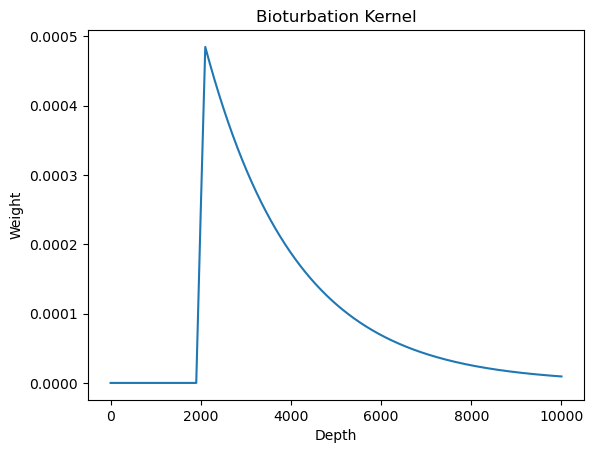

In [36]:
z = np.arange(0, 10001)
weights = bioturbation_weights(z, focal_z=4000, layer_width=1, sed_acc_rate=5, bio_depth=10)

import matplotlib.pyplot as plt
plt.plot(z, weights)
plt.xlabel('Depth')
plt.ylabel('Weight')
plt.title('Bioturbation Kernel')
plt.show()

## ClimToProxyClim.R
Function chunk_matrix()

In [38]:
import warnings

def chunk_matrix(timepoints, width, climate_matrix, start_year=None):
    """
    Compute block-averaged climate values centered on each timepoint.

    Parameters
    ----------
    timepoints : list or array
        Timepoints at which to average the climate signal.
    width : int
        Width (in years) of the averaging window.
    climate_matrix : np.ndarray
        Climate signal, typically shape (years, ...).
    start_year : int or None
        If known, the start year of the climate_matrix (e.g., for annual ts). 
        If None, assumes first row = time index 0.

    Returns
    -------
    np.ndarray
        Array of averaged climate values at each timepoint.
    """
    timepoints = np.asarray(timepoints)
    rel_window = np.arange(width) - int(np.ceil(width / 2))

    n_rows = climate_matrix.shape[0]
    results = []

    for tp in timepoints:
        if start_year is not None:
            center_index = tp - start_year + 1
        else:
            center_index = tp  # Assume row index matches timepoint

        inds = rel_window + center_index
        inds = inds[(inds >= 0) & (inds < n_rows)]

        if len(inds) == 0:
            results.append(np.nan)
            continue

        block = climate_matrix[inds, :]
        results.append(np.nanmean(block))  # Drop NaNs just in case

    return np.array(results)


In [40]:
climate_matrix = np.random.normal(0, 1, size=(5000, 12))  # 5000 years × 12 months
timepoints = np.arange(1000, 3000, 100)  # every 100 years
smoothed = chunk_matrix(timepoints, width=100, climate_matrix=climate_matrix)


Function make_pfm_df()

In [42]:
def make_pfm_df(pfm, stages_key_df):
    """
    Convert PFM output into a long-form tidy DataFrame with stage metadata.

    Parameters
    ----------
    pfm : dict
        Dictionary containing all proxy stages from ClimToProxyClim.
    stages_key_df : DataFrame
        Metadata table with columns ['stage', 'scale', 'label']

    Returns
    -------
    DataFrame
        Long-form DataFrame of proxy simulation stages with metadata joined.
    """
    n_replicates = pfm['proxy_bt_sb_inf_b'].shape[1]
    n_timepoints = len(pfm['timepoints'])

    # --- Replicated proxy stages ---
    stage_cols = [
        "proxy_bt_sb_sampY",
        "proxy_bt_sb_sampYM",
        "proxy_bt_sb_inf_b",
        "proxy_bt_sb_sampYM_b",
        "proxy_bt_sb_inf_b_n",
        "proxy_bt_sb_sampYM_b_n",
        "simulated_proxy",
        "simulated_proxy_cal_err",
        "reconstructed_climate"
    ]

    df = pd.DataFrame({
        col: pfm[col].flatten() for col in stage_cols
    })

    df['timepoints'] = np.tile(pfm['timepoints'], n_replicates)
    df['n_samples'] = np.tile(pfm['n_samples'], n_replicates)
    df['replicate'] = np.repeat(np.arange(1, n_replicates + 1), n_timepoints)

    df = df.melt(
        id_vars=['timepoints', 'n_samples', 'replicate'],
        value_vars=stage_cols,
        var_name='stage',
        value_name='value'
    ).dropna(subset=['value'])

    # --- Single-replicate stages ---
    df2 = pd.DataFrame({
        'timepoints': pfm['timepoints'],
        'n.samples': pfm['n.samples'],
        'replicate': 1,
        'proxy_bt': pfm['proxy_bt'],
        'proxy_bt_sb': pfm['proxy_bt_sb'],
        'clim_signal_ann': pfm['clim_signal_ann'],
        'clim_timepoints_ssr': pfm['clim_timepoints_ssr']
    })

    df2 = df2.melt(
        id_vars=['timepoints', 'n_samples', 'replicate'],
        var_name='stage',
        value_name='value'
    ).dropna(subset=['value'])

    # --- Smoothed signal ---
    df_smoothed = pd.DataFrame({
        'replicate': 1,
        'timepoints': pfm['timepoints_smoothed'],
        'stage': 'clim_signal_smoothed',
        'value': pfm['clim_signal_smoothed']
    })

    # --- Combine all ---
    full_df = pd.concat([df, df2, df_smoothed], ignore_index=True)

    # --- Join with stages key (adds plotting scale, labels, etc.) ---
    full_df = full_df.merge(stages_key_df, on='stage', how='left')

    return full_df


### ClimToProxyClim() subfunctions:
Function clim_to_proxy_clim() and helper functions

In [ ]:
def is_rapid_case(bio_depth, sed_acc_rate, layer_width, n_samples, habitat_weights):
    return (
        np.ndim(bio_depth) == 0 and
        np.ndim(sed_acc_rate) == 0 and
        np.ndim(layer_width) == 0 and
        np.ndim(n_samples) == 0 and
        isinstance(habitat_weights, np.ndarray) and habitat_weights.ndim == 1
    )


def sample_indices(prob_weights, total_samples):
    """
    Sample indices according to probability weights.
    Equivalent to R's sample(..., prob=..., replace=TRUE).
    """
    prob_weights = np.asarray(prob_weights)
    prob_weights /= prob_weights.sum()
    return np.random.choice(len(prob_weights), size=total_samples, p=prob_weights, replace=True)


In [ ]:
import numpy as np
import pandas as pd
from bioturbation_weights import bioturbation_weights
from proxy_conversion import proxy_conversion
from make_pfm_df import make_pfm_df
from chunk_matrix import chunk_matrix
from sample_indices import sample_indices
from is_rapid_case import is_rapid_case


def clim_to_proxy_clim(
    clim_signal,
    timepoints,
    calibration_type="identity",
    calibration=None,
    slp_int_means=None,
    slp_int_vcov=None,
    noise_type=None,
    plot_sig_res=100,
    habitat_weights=None,
    habitat_wt_args=None,
    bio_depth=10,
    sed_acc_rate=50,
    layer_width=1,
    sigma_meas=0,
    sigma_ind=0,
    meas_bias=0,
    scale_noise=None,
    n_samples=np.inf,
    n_replicates=1,
    top_of_core=None,
    n_bd=3
):
    # -------------------------------
    # Step 1: Input preparation
    # -------------------------------
    timepoints = np.asarray(timepoints)
    n_timepoints = len(timepoints)
    if isinstance(clim_signal, pd.DataFrame):
        clim_signal = clim_signal.values

    if top_of_core is None:
        top_of_core = 0

    min_clim_time = 0
    max_clim_time = clim_signal.shape[0] - 1

    if noise_type is None:
        noise_type = "multiplicative" if calibration_type == "MgCa" else "additive"
    if scale_noise is None:
        scale_noise = calibration_type != "identity"
    if calibration is None:
        calibration = {
            "MgCa": "Ten planktonic species_350-500",
            "Uk37": "Mueller global",
            "identity": None
        }[calibration_type]

    # -------------------------------
    # Step 2: Calibration conversion
    # -------------------------------
    if calibration_type != "identity":
        proxy_clim_signal = proxy_conversion(
            temperature=clim_signal,
            calibration_type=calibration_type,
            calibration=calibration,
            slp_int_means=slp_int_means,
            slp_int_vcov=slp_int_vcov,
            point_or_sample="point",
            n=1
        )
    else:
        proxy_clim_signal = clim_signal

    # -------------------------------
    # Step 3: Optional smoothed signal
    # -------------------------------
    if plot_sig_res is not None:
        timepoints_smoothed = np.arange(min_clim_time - 1, max_clim_time - 1, plot_sig_res)
        clim_signal_smoothed = chunk_matrix(timepoints_smoothed, plot_sig_res, clim_signal)
    else:
        timepoints_smoothed = None
        clim_signal_smoothed = None

    # -------------------------------
    # Step 4: Simulate proxy signal (Rapid or Slow, inlined)
    # -------------------------------
    use_rapid = is_rapid_case(bio_depth, sed_acc_rate, layer_width, n_samples, habitat_weights)

    proxy_bt = []
    proxy_bt_sb = []
    proxy_bt_sb_sampY = []
    proxy_bt_sb_sampYM = []

    for i, tp in enumerate(timepoints):
        # Set bioturbation window
        if use_rapid:
            bio_ts = int(1000 * bio_depth / sed_acc_rate)
            layer_yrs = int(np.ceil(1000 * layer_width / sed_acc_rate))
        else:
            bio_ts = int(1000 * bio_depth / sed_acc_rate[i])
            layer_yrs = int(np.ceil(1000 * layer_width / sed_acc_rate[i]))

        first_tp = -bio_ts - layer_yrs // 2
        last_tp = n_bd * bio_ts
        bioturb_window = np.arange(first_tp, last_tp + 1)

        # Get bioturbation weights
        weights = bioturbation_weights(
            z=bioturb_window,
            focal_z=0 if use_rapid else tp,
            layer_width=layer_width if use_rapid else layer_width[i],
            sed_acc_rate=sed_acc_rate if use_rapid else sed_acc_rate[i],
            bio_depth=bio_depth,
            scale="time"
        )

        # Define seasonal weights
        if use_rapid:
            hab_wts = habitat_weights / habitat_weights.sum()
            w_season = np.outer(weights, hab_wts)
        else:
            hab_wts = habitat_weights[i] / habitat_weights[i].sum()
            w_season = weights[:, None] * hab_wts

        w_season /= w_season.sum()
        proxy_window = proxy_clim_signal[(tp + bioturb_window).clip(min=0, max=proxy_clim_signal.shape[0] - 1)]

        # Compute proxy signal
        proxy_bt.append((np.outer(weights, np.ones(proxy_clim_signal.shape[1])) * proxy_window).sum())
        proxy_bt_sb.append((w_season * proxy_window).sum())

        # Aliasing
        ns = n_samples if use_rapid else n_samples[i]
        if np.isinf(ns):
            proxy_bt_sb_sampYM.append([np.nan] * n_replicates)
            proxy_bt_sb_sampY.append([np.nan] * n_replicates)
        else:
            ns = int(ns)
            prob_weights = w_season.flatten()
            samples = sample_indices(prob_weights, ns * n_replicates)
            vals = proxy_window.reshape(-1, proxy_window.shape[-1])[samples]
            vals = vals.reshape(n_replicates, ns, -1).mean(axis=1).mean(axis=1)
            proxy_bt_sb_sampYM.append(vals)
            proxy_bt_sb_sampY.append(vals)

    # Convert to arrays
    proxy_bt = np.array(proxy_bt)
    proxy_bt_sb = np.array(proxy_bt_sb)
    proxy_bt_sb_sampYM = np.array(proxy_bt_sb_sampYM)
    proxy_bt_sb_sampY = np.array(proxy_bt_sb_sampY)

    # -------------------------------
    # Step 5: Add bias and noise
    # -------------------------------
    sigma_ind_scaled = sigma_ind / np.sqrt(n_samples) if np.isfinite(n_samples) else 0
    sigma_meas_ind = np.sqrt(sigma_meas**2 + sigma_ind_scaled**2)

    if noise_type == "additive":
        noise = np.random.normal(0, sigma_meas_ind, size=proxy_bt_sb_sampYM.shape)
        bias = np.random.normal(0, meas_bias, size=(n_replicates,))
        proxy_bt_sb_sampYM_b = proxy_bt_sb_sampYM + bias
        proxy_bt_sb_sampYM_b_n = proxy_bt_sb_sampYM_b + noise
    else:
        noise = np.exp(np.random.normal(0, sigma_meas_ind, size=proxy_bt_sb_sampYM.shape))
        bias = np.exp(np.random.normal(0, meas_bias, size=(n_replicates,)))
        proxy_bt_sb_sampYM_b = proxy_bt_sb_sampYM * bias
        proxy_bt_sb_sampYM_b_n = proxy_bt_sb_sampYM_b * noise

    # -------------------------------
    # Step 6: Calibration error and back-conversion
    # -------------------------------
    if calibration_type != "identity":
        recon_temp = proxy_conversion(
            proxy_val=proxy_bt_sb_sampYM_b_n,
            calibration_type=calibration_type,
            calibration=calibration,
            slp_int_means=slp_int_means,
            slp_int_vcov=slp_int_vcov,
            point_or_sample="point",
            n=1
        )
        recon_proxy = proxy_conversion(
            temperature=recon_temp,
            calibration_type=calibration_type,
            calibration=calibration,
            slp_int_means=slp_int_means,
            slp_int_vcov=slp_int_vcov,
            point_or_sample="sample",
            n=n_replicates
        )
    else:
        recon_temp = proxy_bt_sb_sampYM_b_n
        recon_proxy = proxy_bt_sb_sampYM_b_n

    # -------------------------------
    # Step 7: Assemble outputs
    # -------------------------------
    simulated_proxy = proxy_bt_sb_sampYM_b_n if np.isfinite(n_samples) else proxy_bt_sb

    PFM = {
        "proxy.bt": proxy_bt,
        "proxy.bt.sb": proxy_bt_sb,
        "proxy.bt.sb.sampY": proxy_bt_sb_sampY,
        "proxy.bt.sb.sampYM": proxy_bt_sb_sampYM,
        "proxy.bt.sb.sampYM.b": proxy_bt_sb_sampYM_b,
        "proxy.bt.sb.sampYM.b.n": proxy_bt_sb_sampYM_b_n,
        "simulated.proxy": simulated_proxy,
        "simulated.proxy.cal.err": recon_proxy,
        "reconstructed.climate": recon_temp,
        "timepoints": timepoints,
        "n.samples": n_samples,
        "clim.signal.ann": clim_signal[timepoints].mean(axis=1),
        "clim.timepoints.ssr": chunk_matrix(timepoints, plot_sig_res, clim_signal)
        if plot_sig_res is not None else None,
        "timepoints.smoothed": timepoints_smoothed,
        "clim.signal.smoothed": clim_signal_smoothed
    }

    sim_df = pd.DataFrame({
        "timepoints": timepoints,
        "simulated_proxy": simulated_proxy[:, 0] if simulated_proxy.ndim == 2 else simulated_proxy,
        "reconstructed_climate": recon_temp[:, 0] if recon_temp.ndim == 2 else recon_temp
    })

    everything_df = make_pfm_df(PFM)

    return {
        "simulated_proxy": sim_df,
        "smoothed_signal": pd.DataFrame({
            "timepoints": timepoints_smoothed,
            "value": clim_signal_smoothed,
            "stage": "clim.signal.smoothed"
        }) if clim_signal_smoothed is not None else None,
        "everything": everything_df,
        "calibration_pars": {
            "calibration_type": calibration_type,
            "calibration": calibration,
            "slp_int_means": slp_int_means
        }
    }

## GrowthofT.R
Function foram_growth_of_T()

In [43]:
def foram_growth_ft(temperature_K, foram="ruber", norm=False, min_growth_thresh=0):
    """
    Compute growth rate of planktonic foraminifera as a function of temperature (in Kelvin).

    Parameters:
    - temperature_K: temperature values in Kelvin (scalar, list, or np.ndarray)
    - foram: name of foram species
    - norm: if True, normalize to species' max growth
    - min_growth_thresh: values below this fraction of max are set to zero

    Returns:
    - np.ndarray of daily growth rate
    """
    if foram not in l09_cnsts_dic:
        raise ValueError(f"Foram '{foram}' not found in constants dictionary")

    muT1, TA, TL, TH, TAL, TAH = l09_cnsts_dic[foram]
    max_growth = l09_maxgrowth_dic[foram]

    T = np.asarray(temperature_K)

    # Growth rate function from Lombard et al. (2009)
    growth = (
        muT1 * np.exp(TA / 293 - TA / T) /
        (1 + np.exp(TAL / T - TAL / TL) + np.exp(TAH / TH - TAH / T))
    )

    # Threshold below which growth is set to zero
    growth[growth < min_growth_thresh * max_growth] = 0

    # Zero growth below freezing
    growth[T < 271.15] = 0  # -2°C in Kelvin

    if norm:
        growth = growth / max_growth

    return growth
    


In [44]:
T = np.array([280, 285, 290, 295])
growth = foram_growth_ft(temperature_K=T, foram="ruber", norm=True, min_growth_thresh=0.1)


NameError: name 'l09_cnsts_dic' is not defined